In [9]:
import pandas as pd
from pymongo import MongoClient

# MongoDB bağlantısı
client = MongoClient("mongodb://localhost:27017/")
db = client["retail_db"]
retail_data = pd.DataFrame(list(db["retail_data"].find()))
recommendations = pd.DataFrame(list(db["recommendations"].find()))

# Tarih alanını datetime'a çevir
if "InvoiceDate" in retail_data.columns:
    retail_data["InvoiceDate"] = pd.to_datetime(retail_data["InvoiceDate"], utc=True)

In [10]:
import datetime

# RFM için gerekli sütunlar
rfm = retail_data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (retail_data['InvoiceDate'].max() - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum'
}).reset_index()
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Segmentlere ayır
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score','F_Score','M_Score']].sum(axis=1)

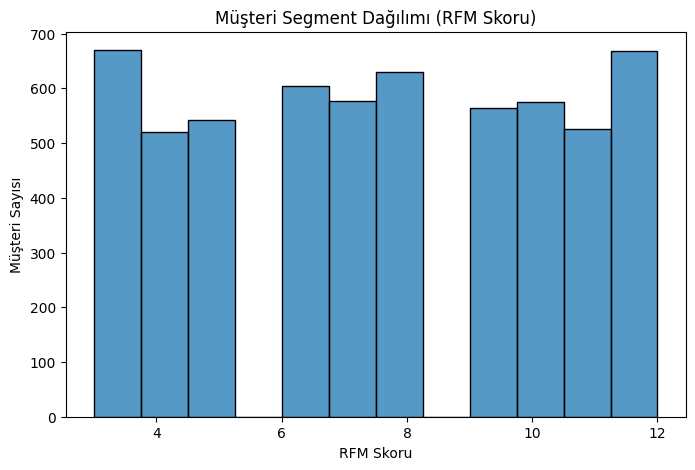

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(rfm['RFM_Score'], bins=12, kde=False)
plt.title('Müşteri Segment Dağılımı (RFM Skoru)')
plt.xlabel('RFM Skoru')
plt.ylabel('Müşteri Sayısı')
plt.show()

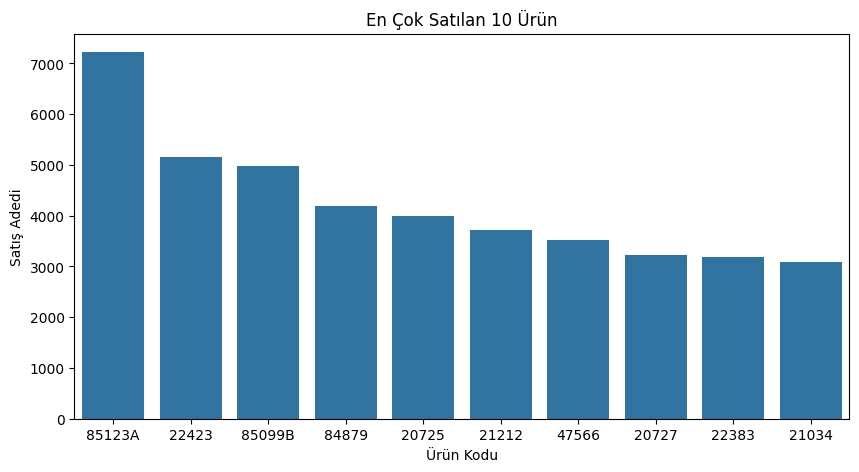

In [12]:
top_products = retail_data['StockCode'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_products.index, y=top_products.values)
plt.title('En Çok Satılan 10 Ürün')
plt.xlabel('Ürün Kodu')
plt.ylabel('Satış Adedi')
plt.show()

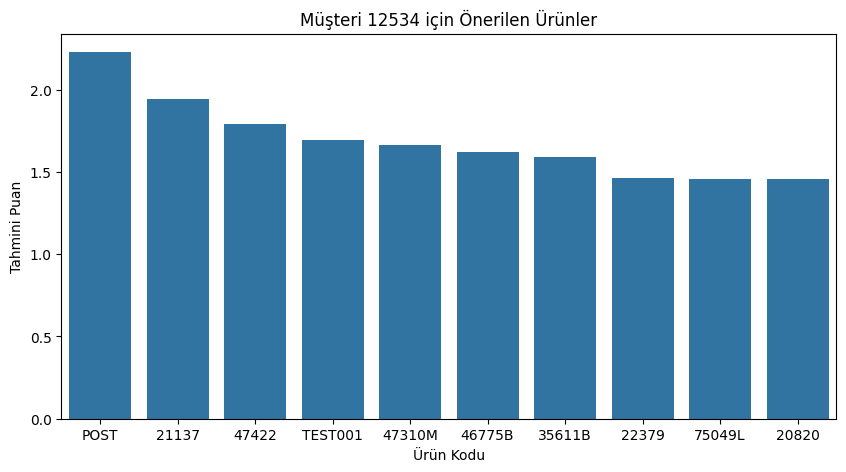

In [13]:
# Örnek bir müşteri için öneriler
customer_id = recommendations['customer_id'].iloc[0]  # veya istediğin bir ID
customer_recs = recommendations[recommendations['customer_id'] == customer_id]

plt.figure(figsize=(10,5))
sns.barplot(x=customer_recs['stock_code'], y=customer_recs['predicted_rating'])
plt.title(f'Müşteri {customer_id} için Önerilen Ürünler')
plt.xlabel('Ürün Kodu')
plt.ylabel('Tahmini Puan')
plt.show()

In [14]:
# En yüksek RFM skoruna sahip müşteriler
vip_customers = rfm.sort_values('RFM_Score', ascending=False).head(10)
print("VIP Müşteriler (En yüksek RFM Skoru):")
print(vip_customers[['CustomerID', 'RFM_Score']])

VIP Müşteriler (En yüksek RFM Skoru):
     CustomerID  RFM_Score
3763      16145         12
879       13230         12
3675      16057         12
847       13198         12
848       13199         12
852       13203         12
3651      16033         12
860       13211         12
3634      16016         12
3631      16013         12


C:\Users\hasan\AppData\Local\Temp\ipykernel_21232\2350095231.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  retail_data['Month'] = retail_data['InvoiceDate'].dt.to_period('M')


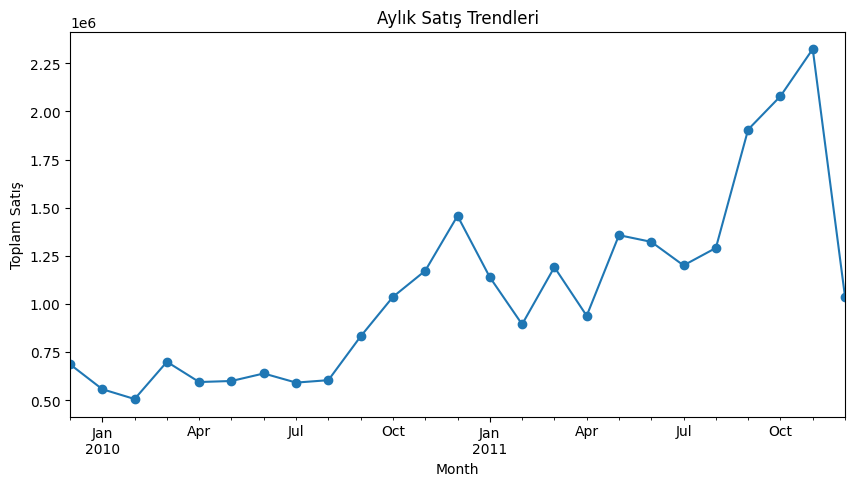

In [15]:
# Aylık satış trendi
if "InvoiceDate" in retail_data.columns:
    retail_data['Month'] = retail_data['InvoiceDate'].dt.to_period('M')
    monthly_sales = retail_data.groupby('Month')['TotalAmount'].sum()
    monthly_sales.plot(kind='line', marker='o', figsize=(10,5), title='Aylık Satış Trendleri')
    plt.ylabel('Toplam Satış')
    plt.show()